In [1]:
import __main__
print(__main__.__package__)

None


In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
from omegaconf import OmegaConf

gpu_config = {
    "seed": 42,
    "device": "cuda",
}

gpu_config = OmegaConf.create(gpu_config)

In [4]:
import torch
import numpy as np

torch.manual_seed(gpu_config.seed)
np.random.seed(gpu_config.seed)

if torch.cuda.is_available and 'cuda' in gpu_config.device:
    torch.cuda.manual_seed(gpu_config.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

os.environ['PYTHONASHSEED'] = str(gpu_config.seed)

In [5]:
dataloader_cfg = {
    "datasets": {
        "data_dir": "/home/cc/efficient-rsnn-bmi/data/datasets",
        "ratio_val": 0.1,
        "random_val": False,
        "extend_data": True,
        "sample_duration": 2.0,
        "remove_segments_inactive": False,
        "p_drop": 0.0,
        "p_insert": 0.0,
        "jitter_sigma": 0.0,
        "dtype": "float32",
        "dt": 4e-3,
    }
}

dataloader_cfg = OmegaConf.create(dataloader_cfg)

In [6]:
from efficient_rsnn_bmi.core.dataloader import get_dataloader

dtype = getattr(torch, dataloader_cfg.datasets.dtype)
dataloader = get_dataloader(dataloader_cfg, dtype=dtype)

In [7]:
monkey_name = "indy"
monkey_files = {
    "indy": {
        "session01": "indy_20160622_01.mat",
        "session02": "indy_20160624_03.mat"
    }
}

In [8]:
filename = list(monkey_files[monkey_name].values())
filename

['indy_20160622_01.mat', 'indy_20160624_03.mat']

In [9]:
train_data, val_data, test_data = dataloader.get_multiple_sessions_data(filename)

Loading indy_20160622_01.mat
[2025-05-27 19:08:29] [INFO] [data.neurobench.dataloader] - Extending data...
Loading indy_20160624_03.mat
[2025-05-27 19:08:54] [INFO] [data.neurobench.dataloader] - Extending data...


In [10]:
print(f"Length of train data: {len(train_data)}")
print(f"Length of val data: {len(val_data)}")
print(f"Length of test data: {len(test_data)}")
print(f"Dimension of 1st spike train data: {(train_data[0][0].shape)}")
print(f"Dimension of 1st of label train data: {(train_data[0][1].shape)}")
print(f"Dimension of 1st spike val data: {(val_data[0][0].shape)}")
print(f"Dimension of 1st of label val data: {(val_data[0][1].shape)}")
print(f"Dimension of 1st spike test data: {(test_data[0][0][0].shape)}")
print(f"Dimension of 1st of label test data: {(test_data[0][0][1].shape)}")

Length of train data: 4722
Length of val data: 974
Length of test data: 2
Dimension of 1st spike train data: torch.Size([500, 96])
Dimension of 1st of label train data: torch.Size([500, 2])
Dimension of 1st spike val data: torch.Size([500, 96])
Dimension of 1st of label val data: torch.Size([500, 2])
Dimension of 1st spike test data: torch.Size([132745, 96])
Dimension of 1st of label test data: torch.Size([132745, 2])


In [11]:
print(f"Data type of 1st spike train data: {train_data[0][0].dtype}")
print(f"Data type of 1st label train data: {train_data[0][1].dtype}")
print(f"Data type of 1st spike val data: {val_data[0][0].dtype}")
print(f"Data type of 1st label val data: {val_data[0][1].dtype}")
print(f"Data type of 1st spike test data: {test_data[0][0][0].dtype}")
print(f"Data type of 1st label test data: {test_data[0][0][1].dtype}")

Data type of 1st spike train data: torch.float32
Data type of 1st label train data: torch.float32
Data type of 1st spike val data: torch.float32
Data type of 1st label val data: torch.float32
Data type of 1st spike test data: torch.float32
Data type of 1st label test data: torch.float32


In [12]:
nb_time_steps = int(dataloader_cfg.datasets.sample_duration / dataloader_cfg.datasets.dt)
nb_outputs = train_data[0][1].shape[1]
nb_inputs = train_data[0][0].shape[1]

print(f"Time Steps: {nb_time_steps}")
print(f"Input Channels: {nb_inputs}")
print(f"Output Channels: {nb_outputs}")

Time Steps: 500
Input Channels: 96
Output Channels: 2


In [13]:
training_config = {
    "training": {
        "batch_size": 250,
        "SG_beta": 20,
        "LB_L2_strength": 100,
        "LB_L2_thresh": 1e-3,
        "UB_L2_strength": 0.01,
        "UB_L2_thresh": 10,
    }
}
training_config = OmegaConf.create(training_config)

In [14]:
device = "cuda:0"

In [15]:
from efficient_rsnn_bmi.experiments.models.rsnn.rsnn_delay import DelayRecurrentSpikingModel

model = DelayRecurrentSpikingModel(
    batch_size = training_config.training.batch_size,
    nb_time_steps = nb_time_steps,
    nb_inputs = nb_inputs,
    device = device,
    dtype = dtype,
)

In [16]:
model_config = {
    "model": {
        "stochastic": False,
        "dropout_p": 0.3,
        "nb_hidden": 1,
        "hidden_size": [64],
        "recurrent": [True],
        "multiple_readout": False,
        "tau_mem_readout": 50e-3,
        "tau_syn_readout": 10e-3,
        "tau_mem": 20e-3,
        "tau_syn": 10e-3,
        "het_timescales": True,
        "het_timescales_readout": True,
        "learn_timescales": True,
        "learn_timescales_readout": True,
        "delta_synapse": False,
        "is_half": True
    }
}

model_config = OmegaConf.create(model_config)

In [17]:
import stork

activation_function = stork.activations.CustomSpike

if model_config.model.stochastic:
    activation_function.escape_noise_type = "sigmoid"
else:
    activation_function.escape_noise_type = "step"

activation_function.escape_noise_params = {"beta": training_config.training.SG_beta}
activation_function.surrogate_type = "SuperSpike"
activation_function.surrogate_params = {"beta": training_config.training.SG_beta}

In [18]:
regs = []

regLB = stork.regularizers.LowerBoundL2(
    strength = training_config.training.LB_L2_strength,
    threshold = training_config.training.LB_L2_thresh,
    dims = False,
)

regUB = stork.regularizers.UpperBoundL2(
    strength = training_config.training.UB_L2_strength,
    threshold = training_config.training.UB_L2_thresh,
    dims = 1,
)

regs.append(regLB)
regs.append(regUB)

In [19]:
from efficient_rsnn_bmi.core.dataloader import compute_input_firing_rates

mean1, mean2 = compute_input_firing_rates(train_data, dataloader_cfg)

torch.Size([500, 96])


In [20]:
dataloader_cfg.datasets.dt

0.004

In [21]:
max_delay = int(0.1 / dataloader_cfg.datasets.dt)
max_delay = max_delay if max_delay%2==1 else max_delay+1

print(f"Max Delay: {max_delay}")

Max Delay: 25


In [22]:
print(f"SIG: {max_delay // 2}")
print(f"a: {-max_delay // 2}")
print(f"b: {max_delay // 2}")

SIG: 12
a: -13
b: 12


In [23]:
from efficient_rsnn_bmi.base.kaiming_uni import KaimingUniformInitializer

hidden_init = KaimingUniformInitializer(
    sig_init=max_delay // 2,
    a=-max_delay // 2,
    b=max_delay // 2,
    scaling=None,
    verbose=True,
)

In [24]:
hidden_init.scaling

In [25]:
from stork.initializers import DistInitializer

readout_init = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
)

In [26]:
delay_config = {
    "delay": {
        "kernel_count": 1,
        "version": "gauss",
        "groups": 1
    }
}

delay_config = OmegaConf.create(delay_config)

In [27]:
print(f"Left Padding: {max_delay - 1}")
print(f"Right Padding: {(max_delay - 1) // 2}")

Left Padding: 24
Right Padding: 12


In [28]:
from stork.layers import Layer
from stork.connections import Connection
from efficient_rsnn_bmi.base.lif import CustomLIFGroup
from efficient_rsnn_bmi.base.inputs import CustomInputGroup
from efficient_rsnn_bmi.base.readout import CustomReadoutGroup
from efficient_rsnn_bmi.base.delay import CustomDelayConnection

input_group = model.add_group(
    CustomInputGroup(
        shape=nb_inputs,
        dropout_p=model_config.model.dropout_p,
    )
)
current_src_grp = input_group
for i in range (model_config.model.nb_hidden):
    hidden_layer = Layer(
        name = f"hidden_{i}",
        model = model,
        size = model_config.model.hidden_size[i],
        input_group = input_group,
        recurrent = model_config.model.recurrent[i],
        regs = regs,
        neuron_class = CustomLIFGroup,
        connection_class=CustomDelayConnection,
        neuron_kwargs={
            "tau_mem": model_config.model.tau_mem,
            "tau_syn": model_config.model.tau_syn,
            "activation": activation_function,
            "dropout_p": model_config.model.dropout_p,
            "het_timescales": model_config.model.het_timescales,
            "learn_timescales": model_config.model.learn_timescales,
            "is_delta_syn": model_config.model.delta_synapse,
        },
        connection_kwargs={
            "kernel_count": delay_config.delay.kernel_count,
            "dilated_kernel_size": max_delay,
            "left_padding": max_delay - 1,
            "right_padding": (max_delay - 1) // 2,
            "version": delay_config.delay.version,
            "groups": delay_config.delay.groups,
            "stride": 1,
            "sig_init": max_delay // 2,
            "sig_threshold": 0.23,
            "sig_stop_ep": 0.25,
        }
    )

    current_src_grp = hidden_layer.output_group

    hidden_init.initialize(hidden_layer)

    if i == 0 and nb_inputs == 192 and train_data is not None:
        with torch.no_grad():
            hidden_layer.connections[0].weight[:, :96] /= mean2 / mean1
        
    # Add single RO group
    readout_group = model.add_group(
        CustomReadoutGroup(
            nb_outputs,
            tau_mem = model_config.model.tau_mem_readout,
            tau_syn = model_config.model.tau_syn_readout,
            het_timescales = model_config.model.het_timescales_readout,
            learn_timescales = model_config.model.learn_timescales_readout,
            initial_state = -1e-2,
            is_delta_syn = model_config.model.delta_synapse,
        )
    )

    con_ro = model.add_connection(
        Connection(current_src_grp, readout_group, dtype=dtype)
    )

    readout_init.initialize(con_ro)

WEIGHT
Before - 
mean: 0.0033, std: 0.1434
After  - 
mean: 0.0033, std: 0.1434
POSITION
Before - 
mean: 0.0061, std: 0.4982
After  - 
mean: -0.4764, std: 7.2091
SIG
Before - 
mean: 0.2300, std: 0.0000
After  - 
mean: 12.0000, std: 0.0000
WEIGHT
Before - 
mean: 0.0008, std: 0.1759
After  - 
mean: 0.0008, std: 0.1759
POSITION
Before - 
mean: 0.0074, std: 0.4978
After  - 
mean: -0.3036, std: 7.1957
SIG
Before - 
mean: 0.2300, std: 0.0000
After  - 
mean: 12.0000, std: 0.0000


In [29]:
# import json
# import matplotlib.pyplot as plt

# # Load data
# with open("init_delay_weight.json", "r") as f:
#     weight = json.load(f)
# with open("init_delay_position.json", "r") as f:
#     position = json.load(f)
# with open("init_delay_sig.json", "r") as f:
#     sig = json.load(f)

# # Plot
# weight_before = weight['before']
# weight_after = weight['after']

# position_before = position['before']
# position_after = position['after']

# sig_before = sig['before']
# sig_after = sig['after']

In [30]:
# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.hist(weight_before, bins=50, color='blue', alpha=0.7)
# plt.title("Before Init")

# plt.subplot(1, 2, 2)
# plt.hist(weight_after, bins=50, color='green', alpha=0.7)
# plt.title("After Init")

# plt.tight_layout()
# plt.show()

In [31]:
# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.hist(position_before, bins=50, color='blue', alpha=0.7)
# plt.title("Before Init")

# plt.subplot(1, 2, 2)
# plt.hist(position_after, bins=50, color='green', alpha=0.7)
# plt.title("After Init")

# plt.tight_layout()
# plt.show()

In [32]:
# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.hist(sig_before, bins=50, color='blue', alpha=0.7)
# plt.title("Before Init")

# plt.subplot(1, 2, 2)
# plt.hist(sig_after, bins=50, color='green', alpha=0.7)
# plt.title("After Init")

# plt.tight_layout()
# plt.show()

In [33]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
CustomDelayConnection(
  (src): CustomInputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Dcls1d(
    96, 64, kernel_count=1 (previous kernel_size), stride=(1,), version=gauss, dilated_kernel_size=(25,) (learnable), bias=False
    (DCK): ConstructKernel1d(96, 64, kernel_count=1, version=gauss, dilated_kernel_size=(25,))
  )
)
CustomDelayConnection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Dcls1d(
    64, 64, kernel_count=1 (previous kernel_size), stride=(1,), version=gauss, dilated_kernel_size=(25,) (learnable), bias=False
    (DCK): ConstructKernel1d(64, 64, kernel_count=1, version=gauss, dilated_kernel_size=(25,))
  )
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=Fa

In [34]:
from efficient_rsnn_bmi.base.loss import RootMeanSquareError

loss_class = RootMeanSquareError()

In [35]:
from stork.optimizers import SMORMS3

opt_kwargs = {
    "lr": 2e-3,
    "lr_P": 0.1,
}

opt_kwargs["eps"] = 1e-5 if dtype == torch.float16 else 1e-16

opt = SMORMS3

In [36]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": 200} # nb of epoch train

In [37]:
import numpy as np
import random
from stork.generators import StandardGenerator

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

generator = StandardGenerator(
    nb_workers=2,
    worker_init_fn=worker_init_fn,
)

In [38]:
model.configure(
    input=model.groups[0],
    output=model.groups[-1],
    loss_stack=loss_class,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=opt_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dataloader_cfg.datasets.dt,
)

In [39]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
CustomDelayConnection(
  (src): CustomInputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Dcls1d(
    96, 64, kernel_count=1 (previous kernel_size), stride=(1,), version=gauss, dilated_kernel_size=(25,) (learnable), bias=False
    (DCK): ConstructKernel1d(96, 64, kernel_count=1, version=gauss, dilated_kernel_size=(25,))
  )
)
CustomDelayConnection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Dcls1d(
    64, 64, kernel_count=1 (previous kernel_size), stride=(1,), version=gauss, dilated_kernel_size=(25,) (learnable), bias=False
    (DCK): ConstructKernel1d(64, 64, kernel_count=1, version=gauss, dilated_kernel_size=(25,))
  )
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=Fa

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


This is the score [ 2.79065058e-01  9.79394335e-05  7.50000036e-04 -5.00000006e-03
 -2.00000007e-03]


/home/cc/efficient-rsnn-bmi/efficient_rsnn_bmi/utils/plotting.py:249: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][-1].legend()


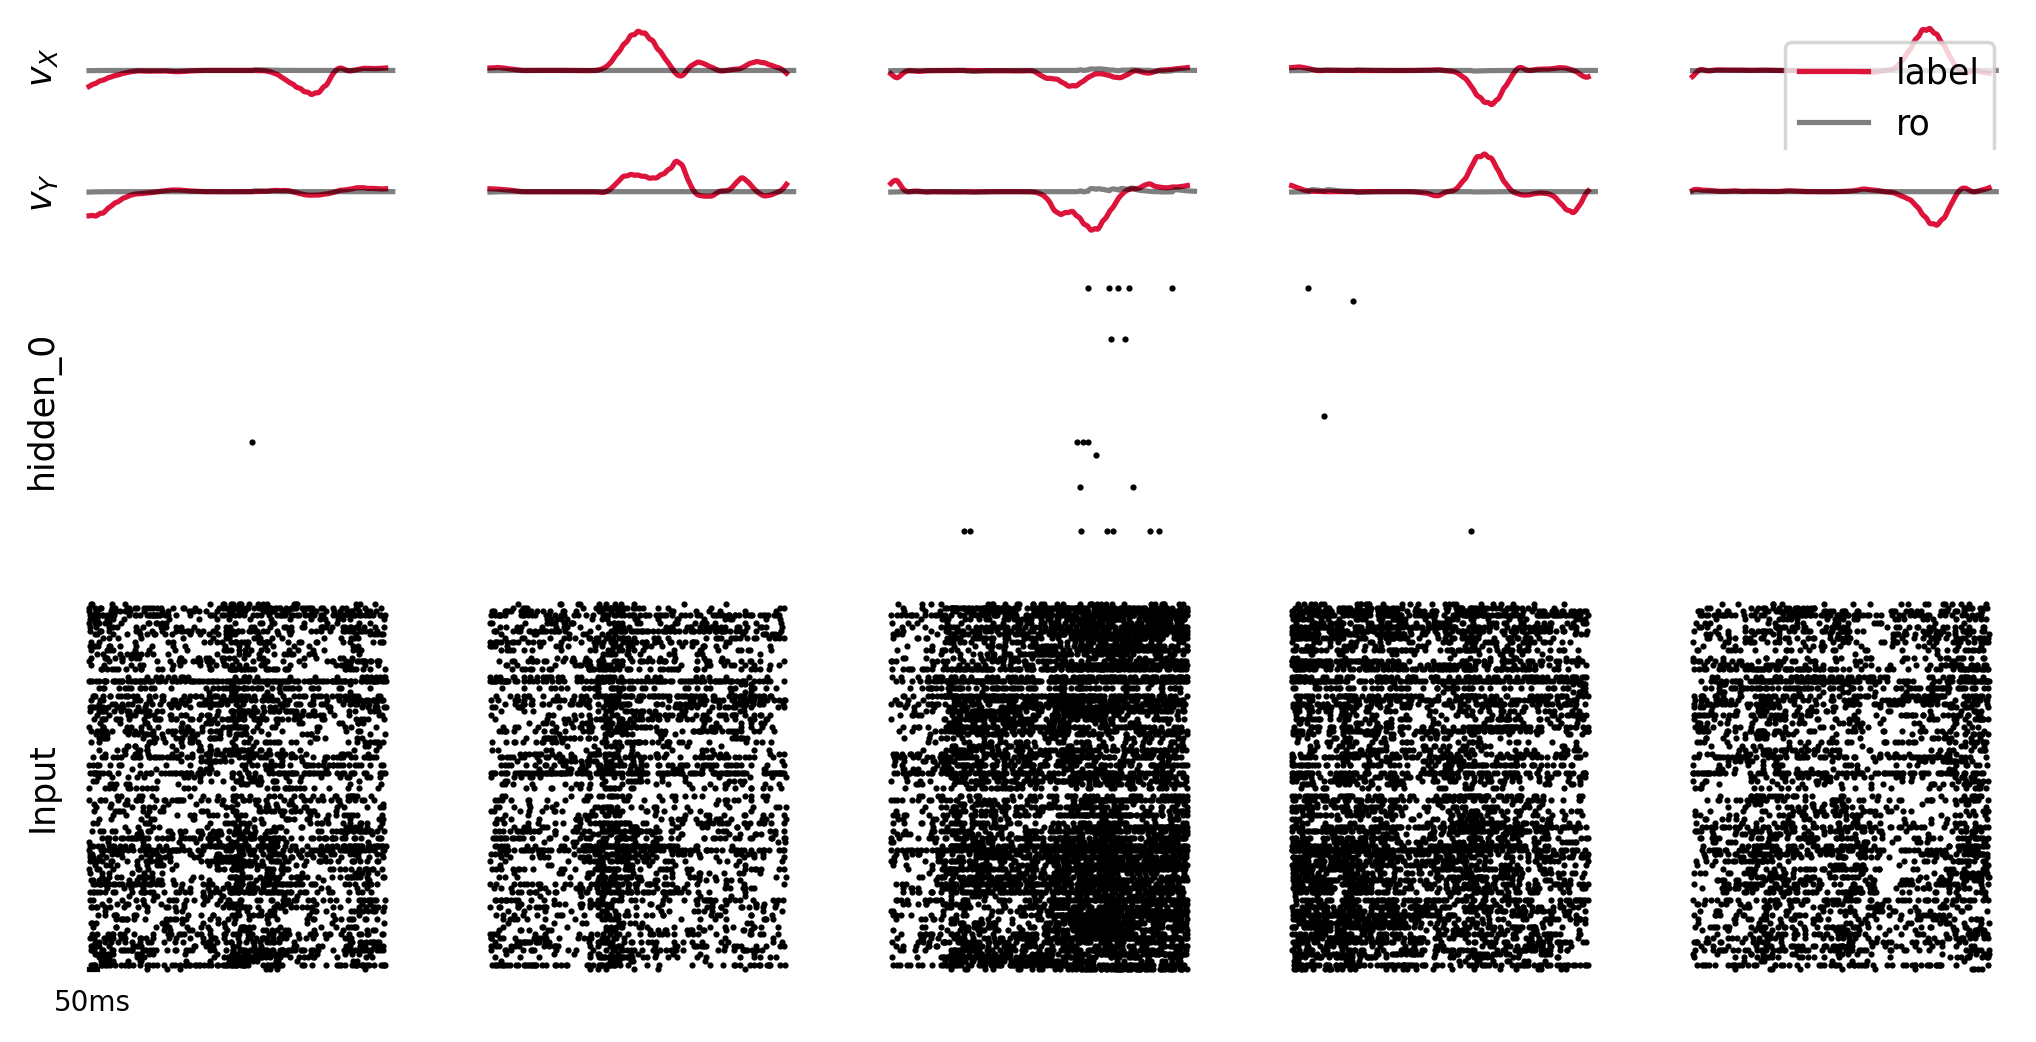

In [40]:
from datetime import datetime
from pathlib import Path
from efficient_rsnn_bmi.utils.plotting import plot_activity_snapshot

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = Path("outputs") / "baseline" / timestamp

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_before.png"
)

In [41]:
history = model.fit_validate(
    train_data,
    val_data,
    nb_epochs=5,
    verbose=True
)

FIT VALIDATE


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

00  loss=0.23 reg_loss=0.00856 r2x=0.0175 r2y=-0.0164 r2=0.000632 -- val_loss=0.266 val_reg_loss=0.194 val_r2x=0.124 val_r2y=-0.0155 val_r2=0.054 t_iter=113.00



Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]

01  loss=0.219 reg_loss=0.024 r2x=0.13 r2y=0.0251 r2=0.0776 -- val_loss=0.241 val_reg_loss=0.00109 val_r2x=0.259 val_r2y=0.223 val_r2=0.241 t_iter=113.71



Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]

02  loss=0.204 reg_loss=0.00663 r2x=0.246 r2y=0.151 r2=0.199 -- val_loss=0.222 val_reg_loss=0.00142 val_r2x=0.381 val_r2y=0.315 val_r2=0.347 t_iter=113.79



Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

03  loss=0.193 reg_loss=0.00563 r2x=0.323 r2y=0.242 r2=0.283 -- val_loss=0.211 val_reg_loss=0.000526 val_r2x=0.434 val_r2y=0.4 val_r2=0.417 t_iter=113.48



Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

04  loss=0.186 reg_loss=0.0044 r2x=0.364 r2y=0.303 r2=0.334 -- val_loss=0.203 val_reg_loss=0.000311 val_r2x=0.48 val_r2y=0.438 val_r2=0.459 t_iter=114.16


In [42]:
history

{'loss': array([0.23000869, 0.21873657, 0.20382828, 0.19289491, 0.18640382]),
 'reg_loss': array([0.0085603 , 0.02401563, 0.00662917, 0.00563494, 0.00440144]),
 'r2x': array([0.01752632, 0.12994737, 0.24621052, 0.32342106, 0.36447368]),
 'r2y': array([-0.01642105,  0.02510526,  0.15068421,  0.24210526,  0.30336842]),
 'r2': array([0.00063158, 0.07757895, 0.19852631, 0.28273684, 0.3338421 ]),
 'val_loss': array([0.26590072, 0.24142341, 0.22216282, 0.2112083 , 0.20290881]),
 'val_reg_loss': array([0.19359237, 0.00109168, 0.00142488, 0.00052589, 0.00031076]),
 'val_r2x': array([0.1235    , 0.259     , 0.38074999, 0.43425   , 0.48025   ]),
 'val_r2y': array([-0.0155 ,  0.22275,  0.3145 ,  0.4    ,  0.438  ]),
 'val_r2': array([0.054  , 0.241  , 0.34725, 0.417  , 0.45875]),
 'pos_logs': [{'dpos0_epoch': 1.414731, 'dpos1_epoch': 1.0785006},
  {'dpos0_epoch': 0.32076326, 'dpos1_epoch': 0.35868827},
  {'dpos0_epoch': 0.26682508, 'dpos1_epoch': 0.25170982},
  {'dpos0_epoch': 0.23060948, 'dpos1_

In [44]:
import torch
import numpy as np
import json

def to_serializable(val):
    if isinstance(val, torch.Tensor):
        return val.item() if val.numel() == 1 else val.tolist()
    elif isinstance(val, np.ndarray):
        return val.tolist()
    elif isinstance(val, (np.floating, np.integer)):
        return val.item()
    elif isinstance(val, dict):
        return {k: to_serializable(v) for k, v in val.items()}
    elif isinstance(val, list):
        return [to_serializable(v) for v in val]
    else:
        return val

In [45]:
serializable_history = to_serializable(history)

with open("training_early_5epoch_delay_result.json", "w") as f:
    json.dump(serializable_history, f, indent=2)

In [50]:
from DCLS.construct.modules import Dcls1d

dcls_generator = (
    conn
    for conn in reversed(model.connections)
    if isinstance(conn.op, Dcls1d)
)

In [51]:
next(dcls_generator)

CustomDelayConnection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Dcls1d(
    64, 64, kernel_count=1 (previous kernel_size), stride=(1,), version=gauss, dilated_kernel_size=(25,) (learnable), bias=False
    (DCK): ConstructKernel1d(64, 64, kernel_count=1, version=gauss, dilated_kernel_size=(25,))
  )
)

In [52]:
model.connections[0].op.SIG.shape

torch.Size([1, 64, 96, 1])

In [1]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if 'P' in name:
        print("=" * 50)
        print(name)
        print(param)
        print("=" * 50)
    else:
        print('Not P')

NameError: name 'model' is not defined

In [2]:
testing = {
    "lr": 1e-2,
    "lr_P": 1e-2,
    "eps": 1e10,
}

In [3]:
testing.pop('lr')

0.01

In [4]:
testing

{'lr_P': 0.01, 'eps': 10000000000.0}

In [57]:
model.connections[0].op.SIG[0, 0, 0, 0].detach()

tensor(12., device='cuda:0')

In [45]:
model.connections[1].op.SIG

Parameter containing:
tensor([[[[12.],
          [12.],
          [12.],
          ...,
          [12.],
          [12.],
          [12.]],

         [[12.],
          [12.],
          [12.],
          ...,
          [12.],
          [12.],
          [12.]],

         [[12.],
          [12.],
          [12.],
          ...,
          [12.],
          [12.],
          [12.]],

         ...,

         [[12.],
          [12.],
          [12.],
          ...,
          [12.],
          [12.],
          [12.]],

         [[12.],
          [12.],
          [12.],
          ...,
          [12.],
          [12.],
          [12.]],

         [[12.],
          [12.],
          [12.],
          ...,
          [12.],
          [12.],
          [12.]]]], device='cuda:0')

In [47]:
model.out.shape

torch.Size([224, 512, 2])

In [49]:
x = torch.randn(250, 64, 13)
print(x.shape)
x = x.squeeze(2) 
print(x.shape)

torch.Size([250, 64, 13])
torch.Size([250, 64, 13])


In [43]:
x = torch.randn(224, 512, 96)

In [45]:
x[:, :500, :].shape

torch.Size([224, 500, 96])

In [50]:
with open("preact.json", "r") as f:
    preact = np.array(json.load(f))

with open("output.json", "r") as f:
    output = np.array(json.load(f))

In [71]:
print(f"Pre activation shape: {preact.shape}")
print(f"Output shape: {output.shape}")

Pre activation shape: (250, 96)
Output shape: (250, 64, 13)


In [ ]:
output_min = output.min()
output_max = output.max()
margin = (output_max - output_min) * 0.1

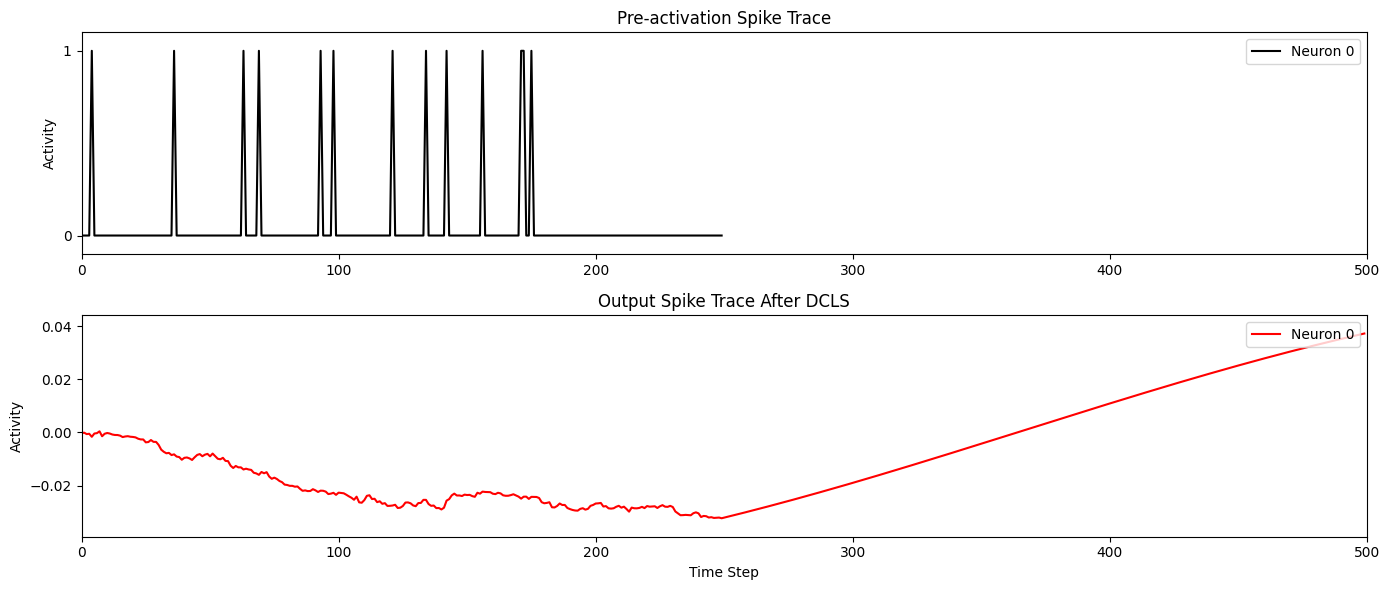

In [ ]:
# Optionally limit to first N neurons
N = 1
preact = preact[:, :N]
output = output[:, :N]

# Time axis
T_preact = preact.shape[0]
T_output = output.shape[0]
T_max = max(T_preact, T_output)

fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=False)

# --- Plot preact as line ---
for i in range(N):
    axs[0].plot(range(T_preact), preact[:, i], label=f"Neuron {i}", color='black')

axs[0].set_ylim(-0.1, 1.1)  # adjust based on spike values
axs[0].set_xlim(0, T_max)
axs[0].set_yticks([0, 1])
axs[0].set_ylabel("Activity")
axs[0].set_title("Pre-activation Spike Trace")
axs[0].legend(loc="upper right")

# --- Plot output as line ---
for i in range(N):
    axs[1].plot(range(T_output), output[:, i], label=f"Neuron {i}", color='red')

axs[1].set_ylim(min(output) - margin, max(output) + margin)
axs[1].set_xlim(0, T_max)
# axs[1].set_yticks([0, 1])
axs[1].set_ylabel("Activity")
axs[1].set_xlabel("Time Step")
axs[1].set_title("Output Spike Trace After DCLS")
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
val_data[0][0].shape

torch.Size([500, 96])

In [69]:
import torch
from DCLS.construct.modules import  Dcls1d 

# Will construct kernels of size 7x7 with 3 elements inside each kernel
m = Dcls1d(96, 64, kernel_count=1, dilated_kernel_size=25, stride=1)
input = torch.rand(250, 96, 1)
# input = input.permute(0, 2, 1)
input.shape

torch.Size([250, 96, 1])

In [70]:
m.stride

(1,)

In [50]:
m

Dcls1d(
  96, 64, kernel_count=1 (previous kernel_size), stride=(1,), version=gauss, dilated_kernel_size=(25,) (learnable)
  (DCK): ConstructKernel1d(96, 64, kernel_count=1, version=gauss, dilated_kernel_size=(25,))
)

In [51]:
import torch.nn.functional as F

print(f"Input Before Padding Shape: {input.shape}")
print(f"Input Before Padding: {input}")
input = F.pad(input, (24, 12), 'constant', 0)
print(f"Input After Padding Shape: {input.shape}")
print(f"Input After Padding: {input}")

Input Before Padding Shape: torch.Size([250, 96, 1])
Input Before Padding: tensor([[[0.1302],
         [0.5621],
         [0.5317],
         ...,
         [0.0131],
         [0.1929],
         [0.8673]],

        [[0.3625],
         [0.8835],
         [0.0587],
         ...,
         [0.9791],
         [0.9648],
         [0.3260]],

        [[0.9280],
         [0.4256],
         [0.4589],
         ...,
         [0.8580],
         [0.4947],
         [0.8520]],

        ...,

        [[0.2045],
         [0.1775],
         [0.4685],
         ...,
         [0.1721],
         [0.7586],
         [0.1713]],

        [[0.8189],
         [0.3230],
         [0.2813],
         ...,
         [0.4954],
         [0.2966],
         [0.4625]],

        [[0.9036],
         [0.4836],
         [0.5378],
         ...,
         [0.3334],
         [0.5298],
         [0.8752]]])
Input After Padding Shape: torch.Size([250, 96, 37])
Input After Padding: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0.

In [52]:
out = m(input)
print(f"Output Shape: {out.shape}")
print(f"Output: {out}")

Output Shape: torch.Size([250, 64, 13])
Output: tensor([[[ 0.0230,  0.0230,  0.0230,  ...,  0.0544,  0.1850,  0.1390],
         [-0.0520, -0.0520, -0.0520,  ..., -0.0478, -0.0535,  0.0493],
         [-0.0994, -0.0994, -0.0994,  ..., -0.0769, -0.0529, -0.0413],
         ...,
         [ 0.0291,  0.0291,  0.0291,  ...,  0.0273, -0.0249,  0.1510],
         [ 0.0738,  0.0738,  0.0738,  ...,  0.0776,  0.1461,  0.3101],
         [-0.0160, -0.0160, -0.0160,  ...,  0.0015,  0.1608,  0.1916]],

        [[ 0.0230,  0.0230,  0.0230,  ...,  0.0616,  0.1149, -0.1274],
         [-0.0520, -0.0520, -0.0520,  ..., -0.0529, -0.0812, -0.0193],
         [-0.0994, -0.0994, -0.0994,  ..., -0.0948, -0.1142, -0.0890],
         ...,
         [ 0.0291,  0.0291,  0.0291,  ...,  0.0216, -0.1034, -0.0751],
         [ 0.0738,  0.0738,  0.0738,  ...,  0.0741,  0.0728,  0.4224],
         [-0.0160, -0.0160, -0.0160,  ...,  0.0071,  0.1818,  0.1764]],

        [[ 0.0230,  0.0230,  0.0230,  ...,  0.0545,  0.1106,  0.0474

In [ ]:
out = out.permute(0, 2, 1)
print(f"Output Shape: {out.shape}")
print(f"Output: {out}")

Output Shape: torch.Size([1, 501, 64])
Output: tensor([[[-0.0424,  0.0043, -0.0653,  ..., -0.0543,  0.0365, -0.0244],
         [-0.0424,  0.0043, -0.0653,  ..., -0.0543,  0.0365, -0.0244],
         [-0.0424,  0.0043, -0.0653,  ..., -0.0543,  0.0365, -0.0244],
         ...,
         [-0.1320, -0.2182, -0.0846,  ..., -0.1178,  0.0601, -0.5986],
         [-0.1779, -0.1976, -0.1081,  ...,  0.1733,  0.0459, -0.2710],
         [-0.0321, -0.1175, -0.0180,  ..., -0.0298, -0.0902, -0.0532]]],
       grad_fn=<PermuteBackward0>)


In [ ]:
out = out.squeeze(0)
print(f"Output Shape: {out.shape}")
print(f"Output: {out}")

Output Shape: torch.Size([501, 64])
Output: tensor([[-0.0424,  0.0043, -0.0653,  ..., -0.0543,  0.0365, -0.0244],
        [-0.0424,  0.0043, -0.0653,  ..., -0.0543,  0.0365, -0.0244],
        [-0.0424,  0.0043, -0.0653,  ..., -0.0543,  0.0365, -0.0244],
        ...,
        [-0.1320, -0.2182, -0.0846,  ..., -0.1178,  0.0601, -0.5986],
        [-0.1779, -0.1976, -0.1081,  ...,  0.1733,  0.0459, -0.2710],
        [-0.0321, -0.1175, -0.0180,  ..., -0.0298, -0.0902, -0.0532]],
       grad_fn=<SqueezeBackward1>)
